# Try to analyze the results of the fit of FORS2 spectra + associated photometry with DSPS

In [1]:
import sys, os, re, copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import jax.numpy as jnp
import jax.scipy as jsc
import pandas as pd
import seaborn as sns
import pickle
import h5py
from tqdm import tqdm

## Gather data in DataFrame

In [2]:
pickle_path = os.path.abspath('DSPS_pickles')
os.listdir(pickle_path)

['fitparams_SPEC37_galex_ageDepMet_Q_successive_fits.pickle',
 'fitparams_SPEC649_galex_ageDepMet_Q_successive_fits.pickle',
 'fitparams_SPEC386_galex_ageDepMet_Q_successive_fits.pickle',
 'fitparams_SPEC441_galex_ageDepMet_Q_successive_fits.pickle',
 'fitparams_SPEC671_galex_ageDepMet_Q_successive_fits.pickle',
 'fitparams_SPEC661_galex_ageDepMet_Q_successive_fits.pickle',
 'fitparams_SPEC294_galex_ageDepMet_Q_successive_fits.pickle',
 'fitparams_galex_successive_fits_185-SPEC408_to_189-SPEC413.pdf',
 'fitparams_SPEC297_galex_ageDepMet_Q_successive_fits.pickle',
 'fitparams_SPEC715_galex_ageDepMet_Q_successive_fits.pickle',
 'fitparams_galex_successive_fits_325-SPEC628_to_329-SPEC636.pdf',
 'fitparams_SPEC702_galex_ageDepMet_Q_successive_fits.pickle',
 'fitparams_SPEC305_galex_ageDepMet_Q_successive_fits.pickle',
 'fitparams_SPEC364_galex_ageDepMet_Q_successive_fits.pickle',
 'fitparams_SPEC624_galex_ageDepMet_Q_successive_fits.pickle',
 'fitparams_SPEC683_galex_ageDepMet_Q_successive

In [3]:
test_file = os.path.join(pickle_path, os.listdir(pickle_path)[0])
test_file

'/home/joseph/PhotoZ_PhD/DSPS_pickles/fitparams_SPEC37_galex_ageDepMet_Q_successive_fits.pickle'

In [4]:
with open(test_file, 'rb') as f:
    test_dict = pickle.load(f)
test_dict

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


OrderedDict([('fors2name', 'SPEC37'),
             ('zobs', 0.68905),
             ('Ns', 1369),
             ('MAH_lgmO', Array(13.669071, dtype=float32)),
             ('MAH_logtc', Array(0.05, dtype=float32)),
             ('MAH_early_index', Array(0.1, dtype=float32)),
             ('MAH_late_index', Array(3.1182284, dtype=float32)),
             ('MS_lgmcrit', Array(13., dtype=float32)),
             ('MS_lgy_at_mcrit', Array(-1., dtype=float32)),
             ('MS_indx_lo', Array(0.7, dtype=float32)),
             ('MS_indx_hi', Array(-0.7, dtype=float32)),
             ('MS_tau_dep', Array(2., dtype=float32)),
             ('Q_lg_qt', Array(1., dtype=float32)),
             ('Q_qlglgdt', Array(-0.50725, dtype=float32)),
             ('Q_lg_drop', Array(-1.01773, dtype=float32)),
             ('Q_lg_rejuv', Array(-0.212307, dtype=float32)),
             ('AV', Array(0.9252306, dtype=float32)),
             ('UV_BUMP', Array(3., dtype=float32)),
             ('PLAW_SLOPE', Array(-

In [5]:
list_of_pickle_dicts = []
for filename in os.listdir(pickle_path):
    if '.pickle' in filename:
        filepath = os.path.join(pickle_path, filename)
        with open(filepath, 'rb') as f:
            filedict = pickle.load(f)
        list_of_pickle_dicts.append(filedict)

In [6]:
dsps_fits_df = pd.DataFrame(list_of_pickle_dicts)
for ser in dsps_fits_df.drop(columns=['fors2name', 'zobs', 'Ns']).columns:
    dsps_fits_df[ser] = dsps_fits_df[ser].astype(np.float32)
dsps_fits_df

,fors2name,zobs,Ns,MAH_lgmO,MAH_logtc,MAH_early_index,MAH_late_index,MS_lgmcrit,MS_lgy_at_mcrit,MS_indx_lo,MS_indx_hi,MS_tau_dep,Q_lg_qt,Q_qlglgdt,Q_lg_drop,Q_lg_rejuv,AV,UV_BUMP,PLAW_SLOPE
0,SPEC37,0.68905,1369,13.669071,0.05,0.1,3.118228,13.000000,-1.0,0.700000,-0.700000,2.0,1.000000,-0.507250,-1.017730,-0.212307,0.925231,3.000000,-0.350000
1,SPEC649,0.40870,1252,13.916237,0.05,0.1,0.173798,13.000000,-1.0,0.700000,-1.598180,2.0,0.901386,-0.200000,-2.000000,-0.219475,0.000000,1.000000,0.000000
2,SPEC386,0.63155,1362,13.641386,0.05,0.1,1.958599,12.432963,-1.0,0.956769,-0.867411,2.0,0.991557,-0.596847,-0.987227,-0.212307,0.384698,1.000000,0.000000
3,SPEC441,0.29001,1255,13.999888,0.05,0.1,0.349577,12.781292,-1.0,0.837282,-1.999398,2.0,0.875880,-0.200000,-1.334682,-0.100000,0.274987,1.001931,-0.133711
4,SPEC671,0.67433,859,14.000000,0.05,0.1,0.954783,12.412607,-1.0,0.700000,-1.038408,2.0,1.000000,-0.507250,-1.017730,-0.212307,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,SPEC265,1.30353,1136,14.000000,0.05,0.1,3.024995,12.478403,-1.0,2.000000,-1.753342,2.0,1.000000,-0.507250,-1.017730,-0.212307,0.124004,3.000000,0.000000
403,SPEC644,0.43582,1362,14.000000,0.05,0.1,7.686776,11.585021,-1.0,0.700000,-0.700000,2.0,0.980885,-1.507827,-0.670637,-0.212307,0.820496,1.000000,0.000000
404,SPEC198,0.44658,1346,14.000000,0.05,0.1,0.670965,12.743626,-1.0,0.700000,-1.282538,2.0,1.217768,-0.517716,-1.925105,-0.215765,1.079077,3.000000,-0.350000
405,SPEC398,0.29370,1380,14.000000,0.05,0.1,0.586090,12.755775,-1.0,0.888807,-1.609812,2.0,1.298019,-0.808382,-0.973619,-0.187810,0.713520,3.000000,-0.350000


## Load corresponding spectral and photometric data

### From `hdf5` file

In [7]:
data_path = os.path.abspath(os.path.join('.', 'Fors2ToStellarPopSynthesis', 'data', 'fors2sl'))
xmatch_filename = 'FORS2spectraGalexKidsPhotom.hdf5'
fors2Spec_filename = 'FORS2spectra.hdf5' # Pas utile ici
starlightSpec_filename = 'SLspectra_manyPoints.hdf5' # Pas utile ici

In [8]:
list_of_h5_dicts = []
with h5py.File(os.path.join(data_path, xmatch_filename), 'r') as f:
    for key in f.keys():
        group = f.get(key)
        group_dict = {}
        for keykey in group.attrs.keys():
            group_dict[keykey] = group.attrs[keykey]
        list_of_h5_dicts.append(copy.deepcopy(group_dict))    
# print(list(group.attrs.keys())) KO - normal, le fichier est fermé. Fonctionnement différent de pickle.

In [9]:
xmatch_df = pd.DataFrame(list_of_h5_dicts)
xmatch_df

,CLASS_STAR,DECJ2000,EXTINCTION_g,EXTINCTION_i,EXTINCTION_r,EXTINCTION_u,FLUXERR_GAAP_H,FLUXERR_GAAP_J,FLUXERR_GAAP_Ks,FLUXERR_GAAP_Y,...,lines,name,num,nuv_flux,nuv_fluxerr,nuv_mag,nuv_magerr,ra,ra_galex,redshift
0,0.094885,-28.366310,0.061679,0.031708,0.042669,0.079157,NaN,259.239624,NaN,323.105255,...,"b'[OII],H{epsilon},H{delta},H{gamma},H{beta},[...",SPEC102,102,2.871513,1.865742,22.754723,0.705620,13.46641,13.462276,0.51330
1,0.000160,-28.391709,0.057656,0.029640,0.039886,0.073995,578.876465,271.253235,624.541199,335.199402,...,"b'[OII],H9,H{beta} ...",SPEC106,106,5.518390,2.237984,22.045467,0.440428,13.46003,13.470677,0.64360
2,0.175907,-28.424881,0.054823,0.028183,0.037926,0.070358,553.975647,273.435272,634.946350,335.875732,...,"b'[OII],H9 ...",SPEC107,107,4.722255,2.058912,22.214626,0.473498,13.46054,13.470075,1.02200
3,0.978268,-28.411893,0.056032,0.028805,0.038763,0.071910,479.450470,228.287079,494.550354,273.153687,...,"b'[OII],H9,K,H{beta},[OIII] ...",SPEC109,109,3.398274,1.822461,22.571854,0.582411,13.45555,13.464808,0.82660
4,0.512666,-28.392098,0.056649,0.029122,0.039189,0.072702,550.595093,258.272949,595.154785,322.220459,...,"b'[OII],H10,K ...",SPEC110,110,86.656600,6.171321,19.055494,0.077340,13.45114,13.446752,0.79700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,0.041400,-28.406491,0.057893,0.029762,0.040050,0.074299,579.864075,268.486725,606.197693,330.740845,...,"b'H9,H8,K,H ...",SPEC9,9,9.029878,2.996898,21.510794,0.360429,13.50219,13.493582,0.29266
546,0.047737,-28.367334,0.062606,0.032184,0.043311,0.080347,565.572388,266.166321,624.611511,330.419525,...,"b'[OII],K,H ...",SPEC91,91,4.311502,2.332795,22.313427,0.587595,13.50394,13.504128,0.68800
547,0.133555,-28.438692,0.056384,0.028986,0.039006,0.072361,556.657837,273.706604,650.384033,338.701935,...,"b'[OII],H{beta},[OIII],H{alpha} ...",SPEC93,93,6.708634,3.112852,21.833414,0.503911,13.50662,13.498856,0.28850
548,0.003030,-28.400564,0.058207,0.029923,0.040267,0.074701,559.626221,260.067902,590.784729,322.735535,...,"b'[OII],H8,K,H,[OIII] ...",SPEC96,96,2.946444,1.456522,22.726753,0.536845,13.48804,13.487534,0.77410


### From `pickle` file

In [10]:
prop_path = os.path.abspath('.')
prop_filename = 'FORS2_spectra_classif_properties_bothExt.pkl'
with open(os.path.join(prop_path, prop_filename), 'rb') as f:
    prop_df = pickle.load(f)
prop_df

,FORS2-SL Id,RA[deg],DEC[deg],Redshift,M(cosmos_u_cfht),M(cosmos_u_new),M(hsc_gHSC),M(hsc_rHSC),M(hsc_iHSC),M(hsc_zHSC),...,M(hsc_iHSC)_z0_e0,M(hsc_zHSC)_z0_e0,M(hsc_yHSC)_z0_e0,Ext law,E(B-V),D4000n,NUVK,Type,Tag,Lines
0,2,13.52997,-28.44776,0.34555,25.656134,25.745916,24.930092,23.645802,22.995878,22.639219,...,9.576632,9.346443,9.088726,Calzetti,0.067182,0.731663,4.599056,E/S0,"SPEC2 , z=0.35, lines=K,H,G,H{beta}","b'K,H,G,H{beta} ..."
1,3,13.52552,-28.42080,0.68660,27.445406,27.456282,26.886576,25.794489,24.913620,24.694273,...,10.212948,10.127766,10.059660,Calzetti,0.076149,0.823350,3.359125,Sbc,"SPEC3 , z=0.69, lines=[OII],H9,K,H,H{beta},[OI...","b'[OII],H9,K,H,H{beta},[OIII],H8 ..."
2,9,13.50219,-28.40641,0.29266,25.645470,25.895012,24.405609,23.158213,22.570601,22.300610,...,9.830420,9.640383,9.454109,Calzetti,0.018776,0.643971,5.126751,E/S0,"SPEC9 , z=0.29, lines=H9,H8,K,H","b'H9,H8,K,H ..."
3,13,13.49261,-28.38272,0.68870,26.768324,26.846340,26.402250,26.112743,25.853102,25.812508,...,11.298798,11.133028,10.969179,Prevot,0.225470,1.034968,1.991021,Scd,"SPEC13 , z=0.69, lines=[OII],H{epsilon},H{delt...","b'[OII],H{epsilon},H{delta},H{beta} ..."
4,19,13.60758,-28.43452,0.48395,26.597130,26.724215,25.864109,24.474184,23.785151,23.457129,...,9.368839,9.169516,8.937725,Prevot,0.199623,0.806435,5.076760,E/S0,"SPEC19 , z=0.48, lines=H10,H9,H8,K,H,H{delta}","b'H10,H9,H8,K,H,H{delta} ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,734,13.68083,-28.23290,0.23012,21.852413,21.929195,21.131676,20.339006,19.937302,19.692709,...,7.437572,7.284735,7.114416,Prevot,0.224031,0.856026,3.635435,Sbc,"SPEC734 , z=0.23, lines=[OII],H9,K,H,H{alpha},NII","b'[OII],H9,K,H,H{alpha},NII ..."
546,735,13.69958,-28.23161,0.36169,23.979353,24.611977,22.326378,20.769735,20.153635,19.881050,...,6.829590,6.670799,6.471434,Prevot,0.091018,0.634273,7.225021,E/S0,"SPEC735 , z=0.36, lines=K,H,G,H{beta}","b'K,H,G,H{beta} ..."
547,736,13.66431,-28.22849,0.55777,26.097153,26.168510,25.715277,25.054239,24.657543,24.507502,...,10.399363,10.336321,10.274342,Prevot,0.201171,0.957919,2.254125,Scd,"SPEC736 , z=0.56, lines=[OII],H9,H{beta},[OIII]","b'[OII],H9,H{beta},[OIII] ..."
548,737,13.62722,-28.22692,0.52001,25.801903,25.909632,25.059542,23.921055,23.381739,23.152592,...,9.593592,9.502151,9.444016,Calzetti,0.001769,0.785689,2.974097,Scd,"SPEC737 , z=0.52, lines=[OII],K,H","b'[OII],K,H ..."


## Associate data

In [11]:
prop_df['FORS2 Name'] = np.array([f'SPEC{int(val)}' for val in prop_df['FORS2-SL Id'].values])

In [12]:
dsps_fits_df['FORS2 num'] = np.array([int(val.split('C')[-1]) for val in dsps_fits_df['fors2name'].values])

In [13]:
prop_df.set_index('FORS2 Name', inplace=True, verify_integrity=True)
prop_df.sort_values('FORS2-SL Id', inplace=True)

In [14]:
prop_df.columns

Index(['FORS2-SL Id', 'RA[deg]', 'DEC[deg]', 'Redshift', 'M(cosmos_u_cfht)',
       'M(cosmos_u_new)', 'M(hsc_gHSC)', 'M(hsc_rHSC)', 'M(hsc_iHSC)',
       'M(hsc_zHSC)', 'M(hsc_yHSC)', 'M(cosmos_u_cfht)_z0',
       'M(cosmos_u_new)_z0', 'M(hsc_gHSC)_z0', 'M(hsc_rHSC)_z0',
       'M(hsc_iHSC)_z0', 'M(hsc_zHSC)_z0', 'M(hsc_yHSC)_z0',
       'M(cosmos_u_cfht)_e0', 'M(cosmos_u_new)_e0', 'M(hsc_gHSC)_e0',
       'M(hsc_rHSC)_e0', 'M(hsc_iHSC)_e0', 'M(hsc_zHSC)_e0', 'M(hsc_yHSC)_e0',
       'M(cosmos_u_cfht)_z0_e0', 'M(cosmos_u_new)_z0_e0', 'M(hsc_gHSC)_z0_e0',
       'M(hsc_rHSC)_z0_e0', 'M(hsc_iHSC)_z0_e0', 'M(hsc_zHSC)_z0_e0',
       'M(hsc_yHSC)_z0_e0', 'Ext law', 'E(B-V)', 'D4000n', 'NUVK', 'Type',
       'Tag', 'Lines'],
      dtype='object')

In [15]:
dsps_fits_df.set_index('fors2name', inplace=True, verify_integrity=True)
dsps_fits_df.sort_values('FORS2 num', inplace=True)
dsps_fits_df.index.name = 'FORS2 Name'

In [16]:
dsps_fits_df.columns

Index(['zobs', 'Ns', 'MAH_lgmO', 'MAH_logtc', 'MAH_early_index',
       'MAH_late_index', 'MS_lgmcrit', 'MS_lgy_at_mcrit', 'MS_indx_lo',
       'MS_indx_hi', 'MS_tau_dep', 'Q_lg_qt', 'Q_qlglgdt', 'Q_lg_drop',
       'Q_lg_rejuv', 'AV', 'UV_BUMP', 'PLAW_SLOPE', 'FORS2 num'],
      dtype='object')

In [17]:
xmatch_df.set_index('name', inplace=True, verify_integrity=True)
xmatch_df.sort_values('num', inplace=True)
xmatch_df.index.name = 'FORS2 Name'

In [18]:
xmatch_df.columns

Index(['CLASS_STAR', 'DECJ2000', 'EXTINCTION_g', 'EXTINCTION_i',
       'EXTINCTION_r', 'EXTINCTION_u', 'FLUXERR_GAAP_H', 'FLUXERR_GAAP_J',
       'FLUXERR_GAAP_Ks', 'FLUXERR_GAAP_Y', 'FLUXERR_GAAP_Z', 'FLUXERR_GAAP_g',
       'FLUXERR_GAAP_i', 'FLUXERR_GAAP_r', 'FLUXERR_GAAP_u', 'FLUX_GAAP_H',
       'FLUX_GAAP_J', 'FLUX_GAAP_Ks', 'FLUX_GAAP_Y', 'FLUX_GAAP_Z',
       'FLUX_GAAP_g', 'FLUX_GAAP_i', 'FLUX_GAAP_r', 'FLUX_GAAP_u',
       'FLUX_RADIUS', 'ID', 'KIDS_TILE', 'MAGERR_GAAP_H', 'MAGERR_GAAP_J',
       'MAGERR_GAAP_Ks', 'MAGERR_GAAP_Y', 'MAGERR_GAAP_Z', 'MAGERR_GAAP_g',
       'MAGERR_GAAP_i', 'MAGERR_GAAP_r', 'MAGERR_GAAP_u', 'MAG_GAAP_H',
       'MAG_GAAP_J', 'MAG_GAAP_Ks', 'MAG_GAAP_Y', 'MAG_GAAP_Z', 'MAG_GAAP_g',
       'MAG_GAAP_i', 'MAG_GAAP_r', 'MAG_GAAP_u', 'Nsp', 'RAJ2000', 'RT', 'RV',
       'Rmag', 'Z_B', 'Z_ML', 'asep_galex', 'asep_kids', 'dec', 'dec_galex',
       'eRV', 'fuv_flux', 'fuv_fluxerr', 'fuv_mag', 'fuv_magerr', 'lines',
       'num', 'nuv_flux', 'nuv_fluxer

In [19]:
newdf = dsps_fits_df.join([prop_df['Lines'],\
                           prop_df['D4000n'],\
                           prop_df['NUVK'],\
                           prop_df['Type']\
                          ])
newdf

,zobs,Ns,MAH_lgmO,MAH_logtc,MAH_early_index,MAH_late_index,MS_lgmcrit,MS_lgy_at_mcrit,MS_indx_lo,MS_indx_hi,...,Q_lg_drop,Q_lg_rejuv,AV,UV_BUMP,PLAW_SLOPE,FORS2 num,Lines,D4000n,NUVK,Type
FORS2 Name,,,,,,,,,,,,,,,,,,,,,
SPEC3,0.68660,1351.0,14.000000,0.05,0.1,1.230930,12.725688,-1.0,0.816993,-0.700000,...,-1.017730,-0.212307,0.826525,1.0,0.00,3.0,"b'[OII],H9,K,H,H{beta},[OIII],H8 ...",0.823350,3.359125,Sbc
SPEC13,0.68870,1028.0,13.827560,0.05,0.1,6.158054,12.704027,-1.0,0.718247,-1.038085,...,-1.017730,-0.212307,0.693011,1.0,0.00,13.0,"b'[OII],H{epsilon},H{delta},H{beta} ...",1.034968,1.991021,Scd
SPEC19,0.48395,1314.0,14.000000,0.05,0.1,6.956109,12.401842,-1.0,2.000000,-2.000000,...,-0.735958,-0.212307,1.340309,1.0,0.00,19.0,"b'H10,H9,H8,K,H,H{delta} ...",0.806435,5.076760,E/S0
SPEC24,0.46612,1129.0,14.000000,0.05,0.1,0.194512,12.941282,-1.0,0.700000,-2.000000,...,-1.941658,-0.100000,0.103111,3.0,-0.35,24.0,"b'[OII],H,K,[OIII] ...",0.779241,4.806089,E/S0
SPEC25,0.44810,1318.0,13.987796,0.05,0.1,10.000000,11.194852,-1.0,0.700000,-0.700000,...,-1.217498,-0.212307,0.341568,3.0,-0.35,25.0,"b'[OII],H,G,H{beta},[OIII] ...",0.833646,2.470889,Scd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SPEC733,0.19553,912.0,14.000000,0.05,0.1,0.374160,12.662801,-1.0,0.700000,-2.000000,...,-2.000000,-0.479144,0.000000,1.0,0.00,733.0,"b'K,H,H{beta},[OIII] ...",0.888688,3.107027,Scd
SPEC734,0.23012,1348.0,13.335047,0.05,0.1,7.432242,12.962683,-1.0,0.895883,-0.700000,...,-2.000000,-0.100000,0.280286,3.0,-0.35,734.0,"b'[OII],H9,K,H,H{alpha},NII ...",0.856026,3.635435,Sbc
SPEC735,0.36169,1360.0,14.000000,0.05,0.1,0.100000,13.000000,-1.0,0.700000,-0.834392,...,-2.000000,-0.215891,0.407080,3.0,-0.35,735.0,"b'K,H,G,H{beta} ...",0.634273,7.225021,E/S0


In [20]:
merged_df = newdf.join(xmatch_df.drop(columns=['num',\
                                               'redshift',\
                                               'lines'\
                                              ]\
                                     )\
                      )
merged_df

,zobs,Ns,MAH_lgmO,MAH_logtc,MAH_early_index,MAH_late_index,MS_lgmcrit,MS_lgy_at_mcrit,MS_indx_lo,MS_indx_hi,...,fuv_flux,fuv_fluxerr,fuv_mag,fuv_magerr,nuv_flux,nuv_fluxerr,nuv_mag,nuv_magerr,ra,ra_galex
FORS2 Name,,,,,,,,,,,,,,,,,,,,,
SPEC3,0.68660,1351.0,14.000000,0.05,0.1,1.230930,12.725688,-1.0,0.816993,-0.700000,...,NaN,NaN,NaN,NaN,4.905293,2.135443,22.173336,0.472773,13.52552,13.524429
SPEC13,0.68870,1028.0,13.827560,0.05,0.1,6.158054,12.704027,-1.0,0.718247,-1.038085,...,NaN,NaN,NaN,NaN,3.221977,1.612464,22.629692,0.543497,13.49261,13.488292
SPEC19,0.48395,1314.0,14.000000,0.05,0.1,6.956109,12.401842,-1.0,2.000000,-2.000000,...,NaN,NaN,NaN,NaN,12.557550,3.319950,21.152737,0.287115,13.60758,13.602319
SPEC24,0.46612,1129.0,14.000000,0.05,0.1,0.194512,12.941282,-1.0,0.700000,-2.000000,...,NaN,NaN,NaN,NaN,4.014068,2.038247,22.391037,0.551445,13.59032,13.599181
SPEC25,0.44810,1318.0,13.987796,0.05,0.1,10.000000,11.194852,-1.0,0.700000,-0.700000,...,NaN,NaN,NaN,NaN,12.557550,3.319950,21.152737,0.287115,13.59405,13.602319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SPEC733,0.19553,912.0,14.000000,0.05,0.1,0.374160,12.662801,-1.0,0.700000,-2.000000,...,11.012729,3.886483,21.295267,0.383258,7.555190,2.761346,21.704386,0.396922,13.63351,13.628613
SPEC734,0.23012,1348.0,13.335047,0.05,0.1,7.432242,12.962683,-1.0,0.895883,-0.700000,...,55.606922,7.885356,19.537182,0.154001,921.703300,19.391645,16.488522,0.022848,13.68083,13.672907
SPEC735,0.36169,1360.0,14.000000,0.05,0.1,0.100000,13.000000,-1.0,0.700000,-0.834392,...,22.656444,5.796451,20.512026,0.277843,30.876852,8.453250,20.175917,0.297318,13.69958,13.687228


<AxesSubplot: xlabel='MAH_late_index', ylabel='Percent'>

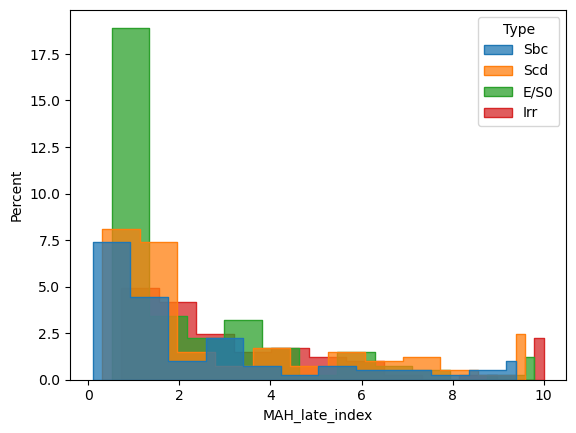

In [21]:
sns.histplot(data=merged_df, x='MAH_late_index', hue='Type', multiple='dodge', element='step', stat='percent')

## Generate spectra with DSPS from fitted params

In [22]:
from fors2tostellarpopsynthesis.filters import FilterInfo
from fors2tostellarpopsynthesis.fitters.fitter_jaxopt import (get_infos_spec,\
                                                              get_infos_mag,\
                                                              get_infos_comb,\
                                                              SSP_DATA,\
                                                              mean_spectrum_ageDepMet_Q,\
                                                              mean_mags_ageDepMet_Q,\
                                                              mean_ugri_ageDepMet_Q,\
                                                              mean_sfr_ageDepMet_Q,\
                                                              ssp_spectrum_fromparam_ageDepMet_Q)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
['galex', 'galex', 'sdss', 'sdss', 'sdss', 'sdss', 'vircam', 'vircam', 'vircam', 'vircam', 'vircam']
['galex_FUV', 'galex_NUV', 'sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'vista_vircam_Z', 'vista_vircam_Y', 'vista_vircam_J', 'vista_vircam_H', 'vista_vircam_Ks']


In [23]:
fit_params_dict = dsps_fits_df.drop(columns=['Ns', 'FORS2 num']).to_dict(orient='index')
test_dict = fit_params_dict[list(fit_params_dict.keys())[0]]
test_dict

{'zobs': 0.6866,
 'MAH_lgmO': 14.0,
 'MAH_logtc': 0.05000000074505806,
 'MAH_early_index': 0.10000000149011612,
 'MAH_late_index': 1.230929970741272,
 'MS_lgmcrit': 12.725687980651855,
 'MS_lgy_at_mcrit': -1.0,
 'MS_indx_lo': 0.8169934153556824,
 'MS_indx_hi': -0.699999988079071,
 'MS_tau_dep': 2.0,
 'Q_lg_qt': 1.0,
 'Q_qlglgdt': -0.5072500109672546,
 'Q_lg_drop': -1.0177299976348877,
 'Q_lg_rejuv': -0.21230700612068176,
 'AV': 0.8265249133110046,
 'UV_BUMP': 1.0,
 'PLAW_SLOPE': 0.0}

In [24]:
z_obs = test_dict.pop('zobs', None)
z_obs, test_dict

(0.6866,
 {'MAH_lgmO': 14.0,
  'MAH_logtc': 0.05000000074505806,
  'MAH_early_index': 0.10000000149011612,
  'MAH_late_index': 1.230929970741272,
  'MS_lgmcrit': 12.725687980651855,
  'MS_lgy_at_mcrit': -1.0,
  'MS_indx_lo': 0.8169934153556824,
  'MS_indx_hi': -0.699999988079071,
  'MS_tau_dep': 2.0,
  'Q_lg_qt': 1.0,
  'Q_qlglgdt': -0.5072500109672546,
  'Q_lg_drop': -1.0177299976348877,
  'Q_lg_rejuv': -0.21230700612068176,
  'AV': 0.8265249133110046,
  'UV_BUMP': 1.0,
  'PLAW_SLOPE': 0.0})

In [25]:
fit_params_dict = dsps_fits_df.drop(columns=['Ns', 'FORS2 num']).to_dict(orient='index')
test_dict = fit_params_dict[list(fit_params_dict.keys())[0]]
z_obs = test_dict.pop('zobs', 0.0)
wl, rest_sed, rest_sed_dust = ssp_spectrum_fromparam_ageDepMet_Q(test_dict, z_obs)

(0.0, 11000.0)

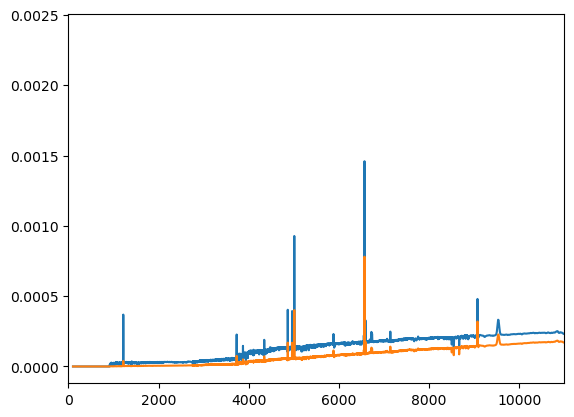

In [26]:
plt.plot(wl, rest_sed)
plt.plot(wl, rest_sed_dust)
plt.xlim(0, 1.1e4)

In [27]:
dict_of_SL_dicts = {}
with h5py.File(os.path.join(data_path, starlightSpec_filename), 'r') as f:
    for key in f.keys():
        group = f.get(key)
        group_dict = {}
        for keykey in group.keys():
            group_dict[keykey] = np.array(group.get(keykey))
        dict_of_SL_dicts[key] = copy.deepcopy(group_dict)
# print(list(group.attrs.keys())) KO - normal, le fichier est fermé. Fonctionnement différent de pickle.

In [28]:
def d4000n(wl, fl):
    _sel_blu = (wl>=3850.)*(wl<=3950.0)
    _sel_red = (wl>=4000.)*(wl<=4100.0)
    n_blu = np.trapz(fl[_sel_blu], x=wl[_sel_blu])
    n_red = np.trapz(fl[_sel_red], x=wl[_sel_red])
    return n_blu/n_red

100%|█████████████████████████████████████████████████████████████████████████████████| 407/407 [00:34<00:00, 11.77it/s]
/tmp/ipykernel_20356/450538968.py:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(d4000_scalarMap)


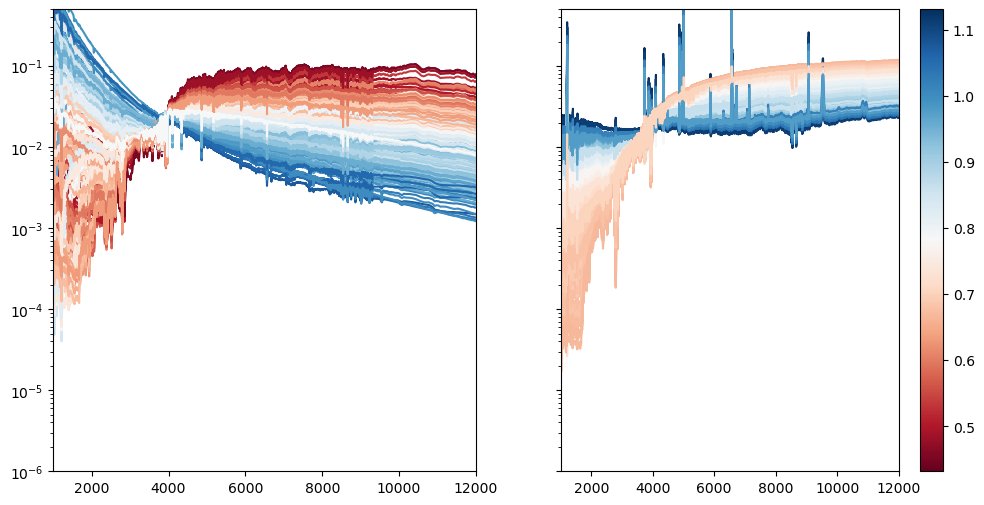

In [29]:
d4000_cmp = plt.get_cmap('RdBu')
d4000_cNorm = colors.Normalize(vmin=0.95*min(merged_df["D4000n"].values), vmax=1.05*max(merged_df["D4000n"].values))
d4000_scalarMap = cmx.ScalarMappable(norm=d4000_cNorm, cmap=d4000_cmp)


f, a = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
a = a.ravel()
for specname in tqdm(fit_params_dict):
    _dict = fit_params_dict[specname]
    z_obs = _dict.pop('zobs', 0.0)
    wl, rest_sed, rest_sed_dust = ssp_spectrum_fromparam_ageDepMet_Q(_dict, z_obs)
    _sel = (wl>3950.) * (wl<4000.)
    _norm = np.trapz(rest_sed[_sel], x=wl[_sel])
    sl_wl = dict_of_SL_dicts[specname]["wl"]
    sl_fl = dict_of_SL_dicts[specname]["fl"]
    _sel = (sl_wl>3950.) * (sl_wl<4000.)
    _norm_sl = np.trapz(sl_fl[_sel], x=sl_wl[_sel])
    #d4000 = merged_df.loc[specname, 'D4000n']
    d4000_sl = d4000n(sl_wl, sl_fl)
    clr = d4000_scalarMap.to_rgba(d4000_sl, alpha=1)
    a[0].plot(sl_wl, sl_fl/_norm_sl, c=clr)
    d4000_dsps = d4000n(wl, rest_sed)
    clr2 = d4000_scalarMap.to_rgba(d4000_dsps, alpha=1)
    a[1].plot(wl, rest_sed/_norm, c=clr2)
    #plt.plot(wl, rest_sed_dust)
a[0].set_xlim(1.0e3, 1.2e4)
a[0].set_yscale('log')
a[0].set_ylim(1.0e-6, 5.0e-1)
a[1].set_xlim(1.0e3, 1.2e4)
plt.colorbar(d4000_scalarMap)

# Dust and NUVK

## Compute Dust as in dsps

In [30]:
from jax import jit
@jit
def D_lambda(lbd, uv_bump):
    return ( uv_bump*jnp.power((350.*lbd), 2.) ) / ( jnp.power((jnp.power(lbd, 2.)-2175.**2.), 2.) + jnp.power((350.*lbd), 2.) )

@jit
def k_lambda_cal(lbd):
    lbd_mum = lbd*1.0e-4
    low_lb = jnp.where(lbd_mum>0.12,\
                       2.659*(-2.156 + 1.509/lbd_mum - 0.198/jnp.power(lbd_mum, 2.) + 0.011/jnp.power(lbd_mum, 3.)) + 4.05,\
                       0.)
    high_lb = jnp.where(lbd_mum<2.20, 2.659*(-1.857 + 1.040/lbd_mum) + 4.05, 0.0)
    return jnp.where(lbd_mum>0.63, high_lb, low_lb)

@jit
def k_lambda_L02(lbd):
    lbd_mum = lbd*1.0e-4
    k_lamb = jnp.where(lbd_mum>0.097,\
                       5.472 + 0.671/lbd_mum - 9.218e-3/jnp.power(lbd_mum, 2.) + 2.620e-3/jnp.power(lbd_mum, 3.),\
                       0.)
    return jnp.where(lbd_mum<0.18, k_lamb, 0.)

@jit
def k0_lambda(lbd):
    lbd_mum = lbd*1.0e-4
    return jnp.where(lbd>0.15e4, k_lambda_cal(lbd), k_lambda_L02(lbd))

@jit
def k_lambda(lbd, plaw_slope, uv_bump):
    return k0_lambda(lbd) * jnp.power((lbd/5500), plaw_slope) + D_lambda(lbd, uv_bump)

@jit
def f_att(lbd, av=1., plaw_slope=0., uv_bump=1.):
    a_lambda = k_lambda(lbd, plaw_slope, uv_bump) * av/4.05
    return jnp.power(10, -0.4*a_lambda)

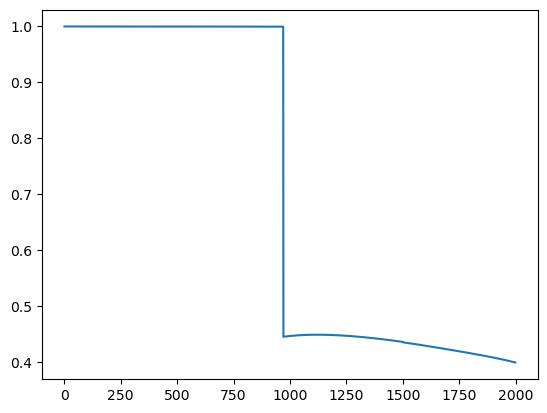

In [31]:
lambdas = jnp.arange(0., 2000.)
fatts = f_att(lambdas, 1., 0.8, 0.2)
plt.plot(lambdas, fatts)

## Fit dust to Starlight spectra to match FORS2

In [32]:
def dist_spec(x, wl_sl, fl_sl, wl_f2, fl_f2, flerr_f2):
    fl_sl_interp = jnp.interp(wl_f2, wl_sl, fl_sl)
    dust_att = f_att(wl_f2, *x)
    fl_sl_att = dust_att*fl_sl_interp
    scale = jsc.integrate.trapezoid(fl_f2, x=wl_f2) / jsc.integrate.trapezoid(fl_sl_att, x=wl_f2)
    elts = jnp.power((scale*fl_sl_att - fl_f2)/flerr_f2, 2.)
    return jnp.sum(elts)

In [33]:
import jax

def get_infos_spec(params, wl_sl, fl_sl, wl_f2, fl_f2, flerr_f2):
    fun_min = dist_spec(params, wl_sl, fl_sl, wl_f2, fl_f2, flerr_f2)
    jacob_min = jax.jacfwd(dist_spec)(params, wl_sl, fl_sl, wl_f2, fl_f2, flerr_f2)
    #covariance matrix of parameters
    inv_hessian_min = jax.scipy.linalg.inv(jax.hessian(dist_spec)(params, wl_sl, fl_sl, wl_f2, fl_f2, flerr_f2))
    return params, fun_min, jacob_min, inv_hessian_min

In [34]:
dict_of_f2_dicts = {}
with h5py.File(os.path.join(data_path, xmatch_filename), 'r') as f:
    for key in f.keys():
        group = f.get(key)
        group_dict = {}
        for keykey in group.keys():
            group_dict[keykey] = np.array(group.get(keykey))
        group_dict["zobs"] = group.attrs.get('redshift')
        dict_of_f2_dicts[key] = copy.deepcopy(group_dict)

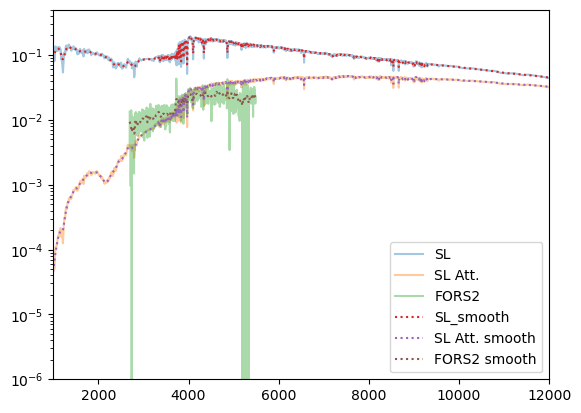

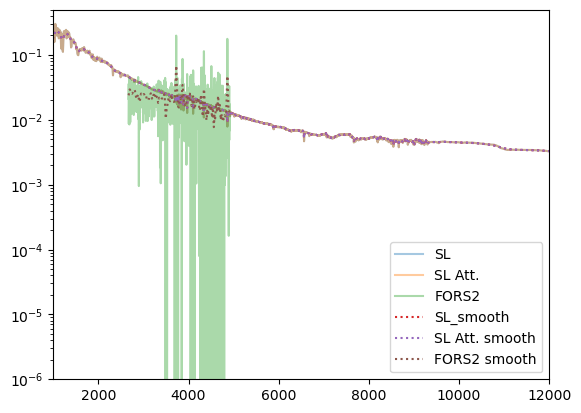

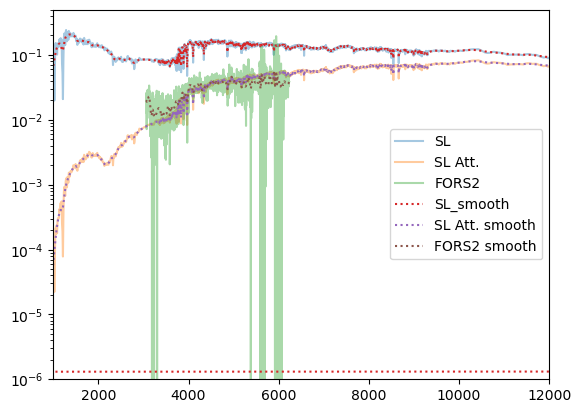

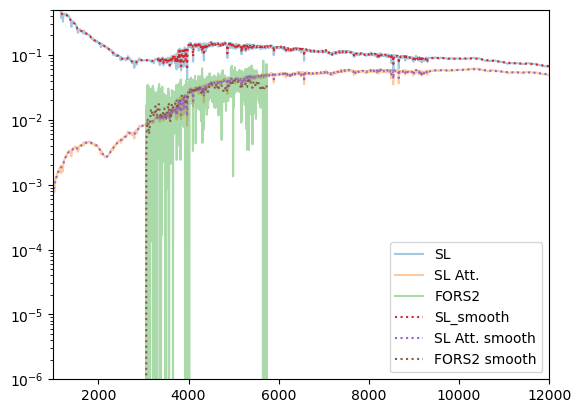

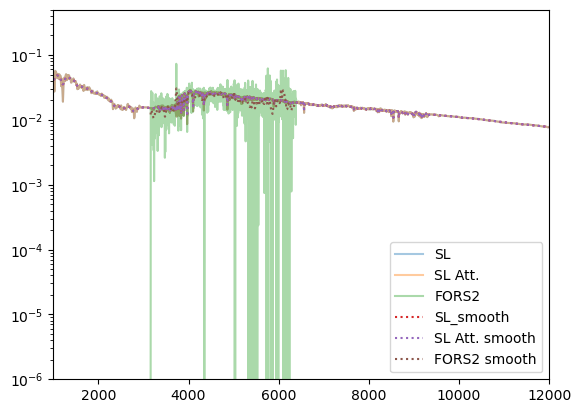

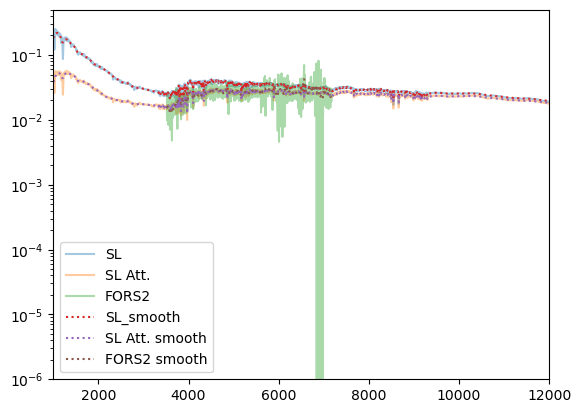

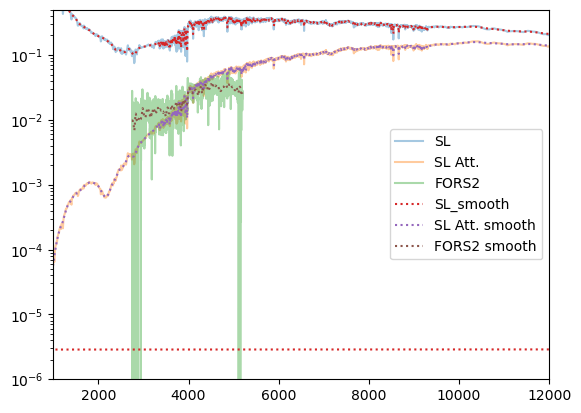

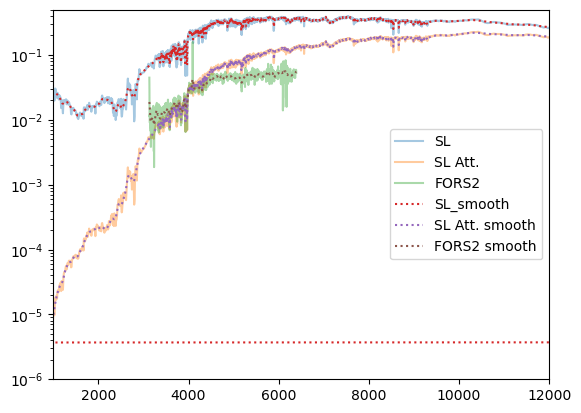

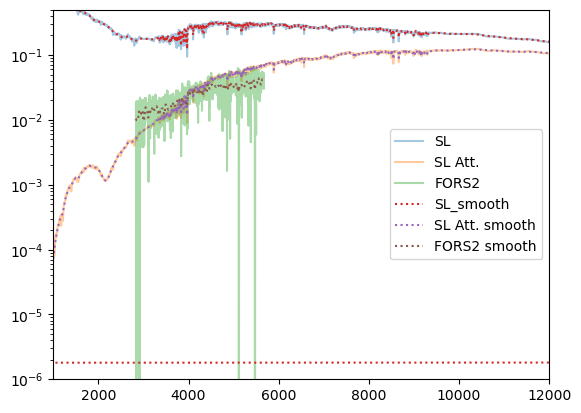

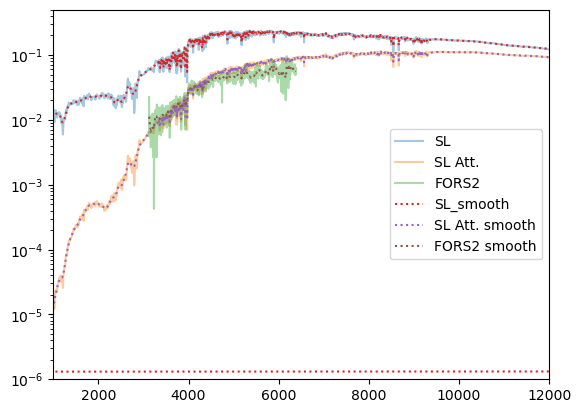

In [35]:
from scipy.ndimage import gaussian_filter1d
import jaxopt
    
lbfgsb_spec = jaxopt.ScipyBoundedMinimize(fun=dist_spec, method="L-BFGS-B", maxiter=5000)

for specname in list(fit_params_dict.keys())[:10]:
    params_dict = fit_params_dict[specname]
    z_obs = dict_of_f2_dicts[specname]["zobs"]
    wl_sl = jnp.array(dict_of_SL_dicts[specname]["wl"])
    fl_sl_raw = jnp.array(dict_of_SL_dicts[specname]["fl"])
    fl_sl = gaussian_filter1d(fl_sl_raw, 3)
    wl_f2 = jnp.array(dict_of_f2_dicts[specname]["wl"]) / (1.+z_obs)
    fl_f2_raw = jnp.array(dict_of_f2_dicts[specname]["fl"])
    fl_f2 = gaussian_filter1d(fl_f2_raw, 5)
    flerr_f2 = 1/5 * jnp.sqrt(jnp.power(fl_f2-fl_f2_raw, 2.))
    x0 = jnp.array([1., -0.25, 2.])
    x_min = x0 + jnp.array([-1., -0.1, -1.])
    x_max = x0 + jnp.array([2., 0.25, 1.])
    opt_res = lbfgsb_spec.run(x0, (x_min, x_max),\
                              wl_sl, fl_sl, wl_f2, fl_f2, flerr_f2)
    #opt_res = jsc.optimize.minimize(dist_spec, x0, tuple(wl_sl, fl_sl, wl_f2, fl_f2, flerr_f2), method="BFGS")
    fl_sl_att = f_att(wl_sl, *opt_res.params)*fl_sl_raw
    _sel_f2 = (wl_f2>3950.) * (wl_f2<4000.)
    _sel_sl = (wl_sl>3950.) * (wl_sl<4000.)
    norm_sl = jsc.integrate.trapezoid(fl_sl_raw[_sel_sl], x=wl_sl[_sel_sl])
    norm_sl_att = jsc.integrate.trapezoid(fl_sl_att[_sel_sl], x=wl_sl[_sel_sl])
    norm_f2 = jsc.integrate.trapezoid(fl_f2_raw[_sel_f2], x=wl_f2[_sel_f2])
    plt.plot(wl_sl, fl_sl_raw/norm_sl_att, label='SL', alpha=0.4)
    plt.plot(wl_sl, fl_sl_att/norm_sl_att, label='SL Att.', alpha=0.4)
    plt.plot(wl_f2, fl_f2_raw/norm_f2, label='FORS2', alpha=0.4)
    plt.plot(wl_sl, fl_sl/norm_sl_att, label='SL_smooth', ls=':')
    plt.plot(wl_sl, fl_sl*f_att(wl_sl, *opt_res.params)/norm_sl_att, label='SL Att. smooth', ls=':')
    plt.plot(wl_f2, fl_f2/norm_f2, label='FORS2 smooth', ls=':')
    plt.xlim(1000, 12000)
    plt.ylim(1e-6, 5.e-1)
    plt.yscale('log')
    plt.legend()
    plt.show()

In [37]:
lbfgsb_spec = jaxopt.ScipyBoundedMinimize(fun=dist_spec, method="L-BFGS-B", maxiter=5000)

AVs, slopes, bumps = [], [], []

for specname in tqdm(fit_params_dict):
    params_dict = fit_params_dict[specname]
    z_obs = dict_of_f2_dicts[specname]["zobs"]
    wl_sl = jnp.array(dict_of_SL_dicts[specname]["wl"])
    fl_sl_raw = jnp.array(dict_of_SL_dicts[specname]["fl"])
    fl_sl = gaussian_filter1d(fl_sl_raw, 3)
    wl_f2 = jnp.array(dict_of_f2_dicts[specname]["wl"]) / (1.+z_obs)
    fl_f2_raw = jnp.array(dict_of_f2_dicts[specname]["fl"])
    fl_f2 = gaussian_filter1d(fl_f2_raw, 5)
    flerr_f2 = 1/5 * jnp.sqrt(jnp.power(fl_f2-fl_f2_raw, 2.))
    x0 = jnp.array([1., -0.25, 2.])
    x_ref = jnp.array([params_dict["AV"], params_dict["PLAW_SLOPE"], params_dict["UV_BUMP"]])
    x_min = x0 + jnp.array([-1., -0.1, -1.])
    x_max = x0 + jnp.array([2., 0.25, 1.])
    opt_res = lbfgsb_spec.run(x0, (x_min, x_max),\
                              wl_sl, fl_sl, wl_f2, fl_f2, flerr_f2)
    AV, slope, bump = opt_res.params
    AVs.append(AV)
    slopes.append(slope)
    bumps.append(bump)
AVS = jnp.array(AVs)
slopes = jnp.array(slopes)
bumps = jnp.array(bumps)
merged_df['AV_SL'] = AVS
merged_df['PLAW_SLOPE_SL'] = slopes
merged_df['UV_BUMP_SL'] = bumps

100%|█████████████████████████████████████████████████████████████████████████████████| 407/407 [01:25<00:00,  4.76it/s]


<AxesSubplot: xlabel='AV', ylabel='AV_SL'>

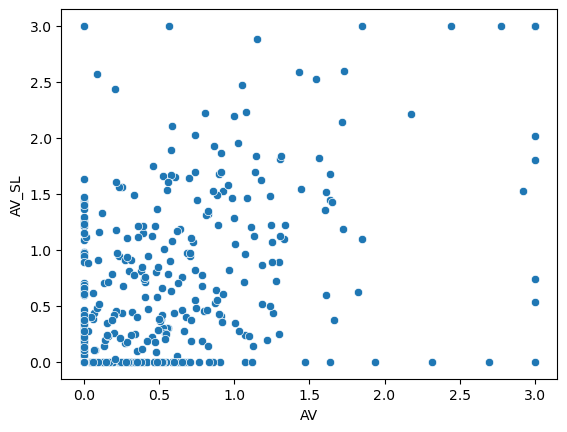

In [38]:
sns.scatterplot(data=merged_df, x='AV', y='AV_SL')

<AxesSubplot: xlabel='PLAW_SLOPE', ylabel='PLAW_SLOPE_SL'>

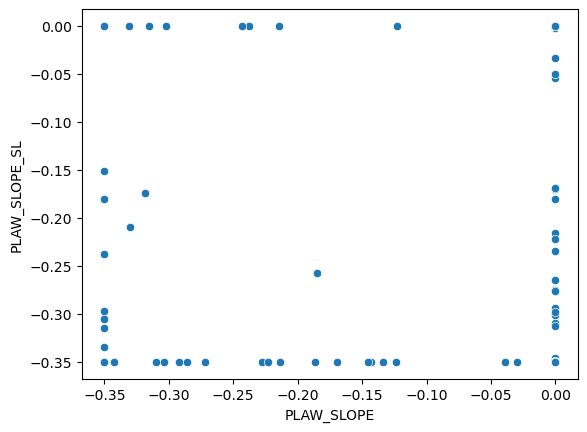

In [39]:
sns.scatterplot(data=merged_df, x='PLAW_SLOPE', y='PLAW_SLOPE_SL')

<AxesSubplot: xlabel='UV_BUMP', ylabel='UV_BUMP_SL'>

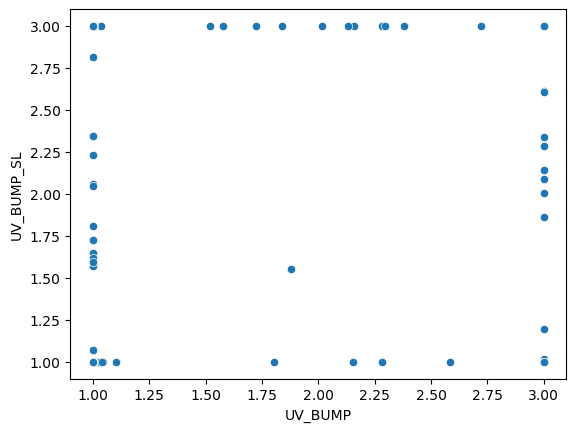

In [40]:
sns.scatterplot(data=merged_df, x='UV_BUMP', y='UV_BUMP_SL')

100%|█████████████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.21it/s]


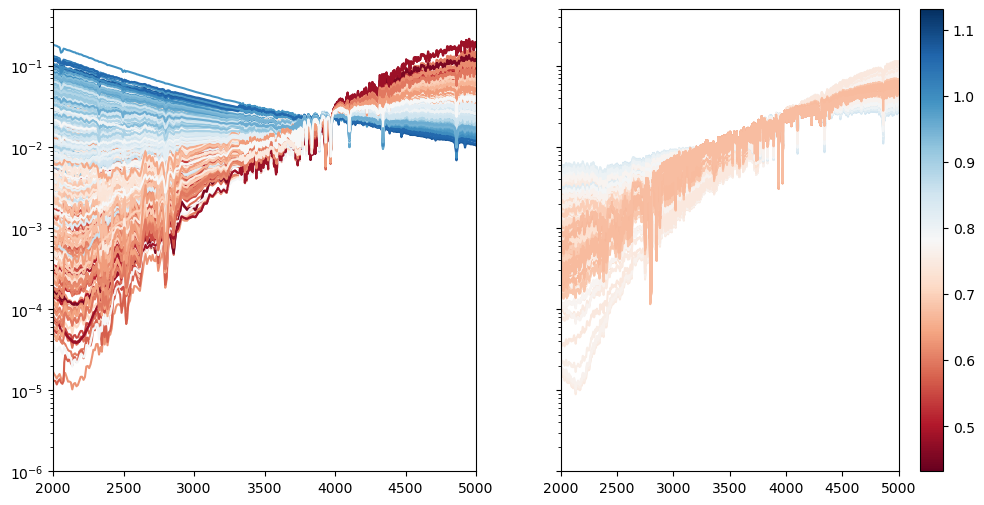

In [41]:
f, a = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
a = a.ravel()
for specname in tqdm(fit_params_dict):
    _dict = fit_params_dict[specname]
    z_obs = _dict.pop('zobs', 0.0)
    wl, rest_sed, rest_sed_dust = ssp_spectrum_fromparam_ageDepMet_Q(_dict, z_obs)
    _sel = (wl>3950.) * (wl<4000.)
    _norm = np.trapz(rest_sed_dust[_sel], x=wl[_sel])
    sl_wl = dict_of_SL_dicts[specname]["wl"]
    sl_fl = dict_of_SL_dicts[specname]["fl"]
    av = merged_df.loc[specname, 'AV_SL']
    plaw = merged_df.loc[specname, 'PLAW_SLOPE_SL']
    uvbmp = merged_df.loc[specname, 'UV_BUMP_SL']
    fl_sl_att = f_att(sl_wl, av, plaw, uvbmp)*sl_fl
    _sel = (sl_wl>3950.) * (sl_wl<4000.)
    _norm_sl = np.trapz(fl_sl_att[_sel], x=sl_wl[_sel])
    #d4000 = merged_df.loc[specname, 'D4000n']
    d4000_sl = d4000n(sl_wl, sl_fl)
    clr = d4000_scalarMap.to_rgba(d4000_sl, alpha=1)
    a[0].plot(sl_wl, fl_sl_att/_norm_sl, c=clr)
    d4000_dsps = d4000n(wl, rest_sed)
    clr2 = d4000_scalarMap.to_rgba(d4000_dsps, alpha=1)
    a[1].plot(wl, rest_sed_dust/_norm, c=clr2)
    #plt.plot(wl, rest_sed_dust)
a[0].set_xlim(2.0e3, 5.0e3)
a[0].set_yscale('log')
a[0].set_ylim(1.0e-6, 5.0e-1)
a[1].set_xlim(2.0e3, 5.0e3)

plt.colorbar(d4000_scalarMap, ax=a[1])

In [47]:
acc_inv_hess = []
acc_jacob = []
for specname in tqdm(fit_params_dict):
    params_dict = fit_params_dict[specname]
    z_obs = dict_of_f2_dicts[specname]["zobs"]
    wl_sl = jnp.array(dict_of_SL_dicts[specname]["wl"])
    fl_sl_raw = jnp.array(dict_of_SL_dicts[specname]["fl"])
    fl_sl = gaussian_filter1d(fl_sl_raw, 3)
    wl_f2 = jnp.array(dict_of_f2_dicts[specname]["wl"]) / (1.+z_obs)
    fl_f2_raw = jnp.array(dict_of_f2_dicts[specname]["fl"])
    fl_f2 = gaussian_filter1d(fl_f2_raw, 5)
    flerr_f2 = 1/5 * jnp.sqrt(jnp.power(fl_f2-fl_f2_raw, 2.))
    params = jnp.array([merged_df.loc[specname, "AV_SL"],\
                        merged_df.loc[specname, "PLAW_SLOPE"],\
                        merged_df.loc[specname, "UV_BUMP"]])
    _, fmin, jac_min, inv_hess_min = get_infos_spec(params, wl_sl, fl_sl, wl_f2, fl_f2, flerr_f2)
    acc_inv_hess.append(inv_hess_min)
    acc_jacob.append(jac_min)
acc_inv_hess = jnp.array(acc_inv_hess)
acc_jacob = jnp.array(acc_jacob)
med_inv_hess = jnp.nanmedian(acc_inv_hess, axis=0)
med_jacob = jnp.nanmedian(acc_jacob, axis=0)

100%|█████████████████████████████████████████████████████████████████████████████████| 407/407 [04:33<00:00,  1.49it/s]


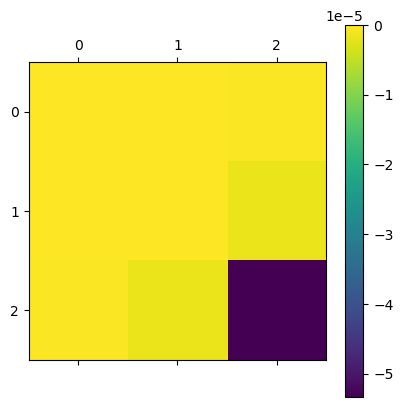

In [48]:
plt.matshow(med_inv_hess)
plt.colorbar()
plt.show()

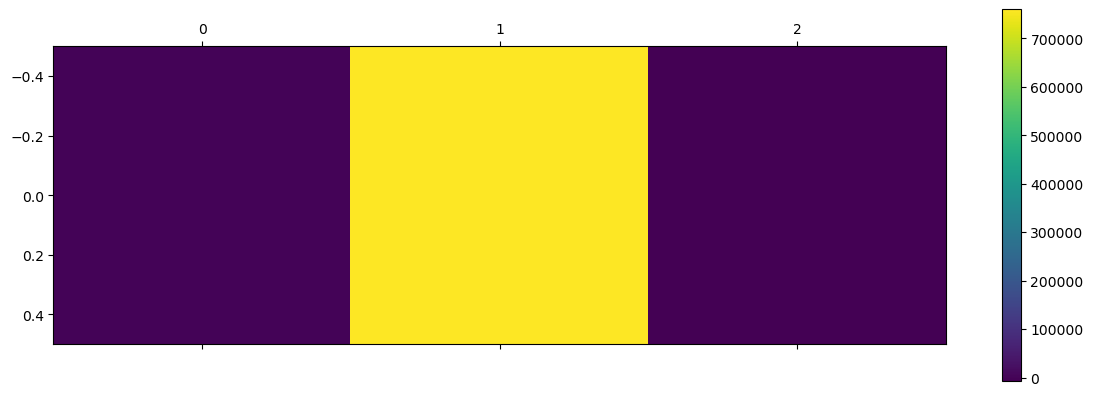

In [53]:
plt.matshow([med_jacob])
plt.colorbar()
plt.show()

In [54]:
print(med_jacob)

[-2.65370399e-01  7.60000521e+05 -7.41989653e+03]
